In [1]:
import numpy as np
from numpy import pi
import pyregion
import graphinglib as gl
from uncertainties import ufloat, umath
from scipy.stats import norm
# import latexify   # only for python <= 3.11

from src.hdu.maps.map import Map

In [2]:
# @latexify.function(use_math_symbols=True)
def pdf(x, sigma, mu):
    return 1 / (np.sqrt(2*pi) * sigma) * np.exp((-(x - mu)**2) / (2*sigma**2))

# pdf

$$ \displaystyle \mathrm{pdf}(x, \sigma, \mu) = \frac{1}{\sqrt{ 2 \pi } \cdot \sigma} \cdot \exp \mathopen{}\left( \frac{-\mathopen{}\left( x - \mu \mathclose{}\right)^{2}}{2 \sigma^{2}} \mathclose{}\right) $$

# Computations of PDF histograms

In [3]:
regions = [
    None,
    pyregion.open("summer_2023/gaussian_fitting/regions/region_1.reg"),
    pyregion.open("summer_2023/gaussian_fitting/regions/region_2.reg"),
    pyregion.open("summer_2023/gaussian_fitting/regions/region_3.reg")
]

def make_pdf_histograms(map_: Map) -> list[gl.Histogram]:
    plottables = []
    for region in regions:
        masked = map_.get_masked_region(region)
        data = np.log(masked.data / np.nanmedian(masked.data))
        # data = masked.data
        stats = masked.data.get_statistics()
        # probability_density = pdf(
        #     x=np.log(masked.data / stats["median"]),
        #     sigma=stats["stddev"],
        #     mu=stats["median"]
        # )
        probability_density = pdf(
            x=data,
            sigma=np.nanstd(data),
            mu=np.nanmedian(data)
        )

        flat = (masked.data/np.nanmedian(masked.data)).flatten()

        bin_width = 2 * masked.uncertainties.get_statistics()["median"]/masked.data.get_statistics()["median"]
        plottables.append(gl.Scatter(
            flat,
            norm.pdf(flat, loc=np.nanmedian(flat), scale=np.nanstd(flat))
        ))
        # plottables.append(gl.Histogram(
        #     data=norm.pdf(flat[~np.isnan(flat)], loc=np.nanmedian(flat), scale=np.nanstd(flat)),
        #     # data=norm.pdf(data[~np.isnan(data)]),
        #     # data=probability_density[~np.isnan(probability_density)],
        #     face_color="black",
        #     edge_color="none",
        #     alpha=1,
        #     normalize=False,
        #     number_of_bins=20,
        #     show_params=False,
        #     # number_of_bins=int(((np.nanmax(probability_density) + bin_width - np.nanmin(probability_density)) 
        #                         # / bin_width))
        #     # number_of_bins=(map_.uncertainties.get_statistics()["median"] / stats["stddev"])
        # ))

    return plottables

def make_simple_histograms(map_: Map) -> list[gl.Histogram]:
    """
    Make a simple count histogram
    """
    plottables = []
    for region in regions:
        masked = map_.get_masked_region(region)
        bin_width = 1
        plottables.append(gl.Histogram(
            data=masked.data[~np.isnan(masked.data)],
            face_color="black",
            edge_color="none",
            alpha=1,
            normalize=False,
            # number_of_bins=20,
            number_of_bins=int(((np.nanmax(masked.data) + bin_width - np.nanmin(masked.data)) / bin_width)),
            show_params=False
        ))

    return plottables

def make_pdf_scatters(map_: Map, normalize: bool=False, fit: bool=False) -> list[gl.Scatter]:
    plottables = []
    for region in regions:
        masked = map_.get_masked_region(region)
        data = (masked.data/np.nanmedian(masked.data)).flatten()
        data = np.sort(data[~np.isnan(data)])
        if normalize: 
            data = np.log(data)
        
        current_plots = [
            gl.Scatter(
                data,
                pdf(data, np.nanstd(data), np.nanmedian(data)),
                # norm.pdf(data, loc=np.nanmedian(data), scale=np.nanstd(data)),
            )
        ]
        if fit:

            current_plots.append(gl.FitFromGaussian(
                current_plots[0]
            ))

        plottables.append(current_plots)

    return plottables

def make_fit_histogram(map_: Map, normalize: bool=False) -> list[gl.Histogram, gl.Curve]:
    plottables = []
    for region in regions:
        masked = map_.get_masked_region(region)
        data = masked.data.flatten()
        data = np.sort(data[~np.isnan(data)])
        bin_width = np.nanmedian(masked.uncertainties)
        if normalize: 
            data = np.log(data/np.nanmedian(data))
            bin_width = umath.log(ufloat(np.nanmedian(masked.data), np.nanmedian(masked.uncertainties))
                             / ufloat(np.nanmedian(masked.data), np.nanmedian(masked.uncertainties))).std_dev
        
        # Create the array of bins, considering that the upper bound is cropped lower to match the bin width
        bins = np.arange(np.nanmin(data), np.nanmax(data) + bin_width*0.99, bin_width)
        hist = np.histogram(data, bins=bins)[0]
        
        current_plots = [
            gl.Histogram(
                data=data,
                face_color="black",
                edge_color="none",
                alpha=1,
                normalize=False,
                number_of_bins=bins,
                show_params=False
            ),
        ]
        scat =gl.Scatter(
            (bins + bin_width/2)[:-1],
            hist,
        )
        # current_plots.append(
        #     gl.FitFromGaussian(
        #         curve_to_be_fit=current_plots[1],
        #         color="blue",
        #         guesses=[
        #             np.max(current_plots[1].y_data),
        #             current_plots[1].x_data[np.argmax(current_plots[1].y_data)],
        #             np.std(current_plots[1].y_data) * np.diff(current_plots[1].x_data)[0],
        #         ],
        #         label="Gaussian fit"
        #     )
        # )

        max_x = scat.x_data[np.argmax(hist)]
        fit = gl.FitFromFunction(
            function=lambda x, A, mu, sigma: A/x * np.exp(-(np.log(x) - mu)**2 / (2*sigma**2)),
            curve_to_be_fit=scat,
            guesses=[
                np.max(hist)*max_x,
                np.log(max_x),
                0.5
            ],
            color="red",
        )
        fit.label = rf"$\mu={fit.parameters[1]:.3f}$" + "\n" + rf"$\sigma={abs(fit.parameters[2]):.3f}$"
        current_plots.append(fit)

        plottables.append(current_plots)

    return plottables

## Random figures

In [15]:
names = [
    "main region",
    "diffuse region",
    "central region",
    "filament region"
]

turbulence_map = Map.load("summer_2023/gaussian_fitting/maps/computed_data_selective/turbulence.fits")
density_map = Map(
    data=Map.load("summer_2023/gaussian_fitting/maps/external_maps/"
                 +"dens_it_sii_sans_fcorr_nii_plus_plusmin_pouss_seuil_errt_1000.fits").data,
    uncertainties=Map.load("summer_2023/gaussian_fitting/maps/external_maps/"
                          +"dens_it_sii_sans_fcorr_nii_plus_pluserr_pouss_seuil_errt_1000.fits").data,
    header=Map.load("summer_2023/gaussian_fitting/maps/external_maps/"
                   +"dens_it_sii_sans_fcorr_nii_plus_plusmin_pouss_seuil_errt_1000.fits").header
)
temperature_map = Map(
    data=Map.load("summer_2023/gaussian_fitting/maps/external_maps/temp_it_nii_8300.fits").data,
    uncertainties=Map.load("summer_2023/gaussian_fitting/maps/external_maps/temp_it_nii_err_8300.fits").data,
    header=Map.load("summer_2023/gaussian_fitting/maps/external_maps/temp_it_nii_8300.fits").header
)

alignment_map = (turbulence_map * 0).get_reprojection_on(density_map)

# Remove pixels that are not present in the alignment map
density_map += alignment_map
temperature_map += alignment_map

figs = []
for name, plottable in zip(names, make_fit_histogram(density_map, normalize=False)):
    fig = gl.Figure(
        x_label="Density [-]",
        y_label=f"PDF in {name}"
    )
    fig.add_elements(*plottable)
    figs.append(fig)
# multifig = gl.MultiFigure.from_grid(figs, (2, 2), size=(10,10))
# multifig.save("summer_2023/gaussian_fitting/figures/density/hist_fit_lognormal.pdf")

# figs = []
for name, plottable in zip(names, make_fit_histogram(turbulence_map, normalize=False)):
    fig = gl.Figure(
        x_label="Turbulence [-]",
        y_label=f"PDF in {name}"
    )
    fig.add_elements(*plottable)
    figs.append(fig)
# multifig = gl.MultiFigure.from_grid(figs, (2, 2), size=(10,10))
# multifig.save("summer_2023/gaussian_fitting/figures/turbulence/hist_fit_lognormal.pdf")

# figs = []
for name, plottable in zip(names, make_fit_histogram(temperature_map, normalize=False)):
    fig = gl.Figure(
        x_label="Temperature [-]",
        y_label=f"PDF in {name}"
    )
    fig.add_elements(*plottable)
    figs.append(fig)
# multifig = gl.MultiFigure.from_grid(figs, (2, 2), size=(10,10))
# multifig.save("summer_2023/gaussian_fitting/figures/temperature/hist_fit_lognormal.pdf")

multifig = gl.MultiFigure.from_grid(figs, (3,4), (20*1.3,11.5*1.3))
multifig.save("figures/sh158/histograms/hist_fit_lognormal.pdf")

## Article Figure

In [4]:
names = [
    "main region",
    "diffuse region",
    "central region",
    "filament region"
]

turbulence_map = Map.load("summer_2023/gaussian_fitting/maps/computed_data_selective/turbulence.fits")
density_map = Map(
    data=Map.load("summer_2023/gaussian_fitting/maps/external_maps/"
                 +"dens_it_sii_sans_fcorr_nii_plus_plusmin_pouss_seuil_errt_1000.fits").data,
    uncertainties=Map.load("summer_2023/gaussian_fitting/maps/external_maps/"
                          +"dens_it_sii_sans_fcorr_nii_plus_pluserr_pouss_seuil_errt_1000.fits").data,
    header=Map.load("summer_2023/gaussian_fitting/maps/external_maps/"
                   +"dens_it_sii_sans_fcorr_nii_plus_plusmin_pouss_seuil_errt_1000.fits").header
)
temperature_map = Map(
    data=Map.load("summer_2023/gaussian_fitting/maps/external_maps/temp_it_nii_8300.fits").data,
    uncertainties=Map.load("summer_2023/gaussian_fitting/maps/external_maps/temp_it_nii_err_8300.fits").data,
    header=Map.load("summer_2023/gaussian_fitting/maps/external_maps/temp_it_nii_8300.fits").header
)

alignment_map = (turbulence_map * 0).get_reprojection_on(density_map)

# Remove pixels that are not present in the alignment map
density_map += alignment_map
temperature_map += alignment_map

figs = []
for name, plottable in zip(names, make_fit_histogram(density_map, normalize=False)):
    fig = gl.Figure(
    )
    fig.add_elements(*plottable)
    figs.append(fig)

for name, plottable in zip(names, make_fit_histogram(turbulence_map, normalize=False)):
    fig = gl.Figure(
    )
    fig.add_elements(*plottable)
    figs.append(fig)

for name, plottable in zip(names, make_fit_histogram(temperature_map, normalize=False)):
    fig = gl.Figure(
    )
    fig.add_elements(*plottable)
    figs.append(fig)

figs_array = np.array(figs).reshape((3,4)).transpose()

# Titles
figs_array[0,1].title = "Sh2-158"
figs_array[1,1].title = "Diffuse Region"
figs_array[2,1].title = "Central Region"
figs_array[3,1].title = "Filament Region"

# Axes

figs_array[3,0].x_axis_name = "Density [cm$^{-3}$]"
figs_array[3,1].x_axis_name = "Turbulence [km s$^{-1}$]"
figs_array[3,2].x_axis_name = "Temperature [K]"

multifig = gl.MultiFigure.from_grid(figs_array.flatten().tolist(), (4,3), (12,12))

multifig.y_label = "Count [pixels]"

multifig.save("figures/sh158/histograms/hist_fit_lognormal_article.pdf")

# Maxime's maps

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.transforms import ScaledTranslation
from astropy.io import fits
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LinearStretch, LogStretch, SqrtStretch
from src.hdu.maps.map import Map
from astropy.wcs import WCS
from string import ascii_lowercase

# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Computer Modern Roman"
# plt.rcParams["text.usetex"] = True

background = Map.load("data/sh158_article/6563_flux_crop_nan_qgh_background.fits")

def format(ax):
    cmap = mpl.colormaps.get_cmap("gray")
    cmap.set_bad(color="k", alpha=1)
    ax.imshow(
        background.data,
        norm=ImageNormalize(background.data, stretch=LogStretch(1000), vmin=float(4.9e-17), vmax=float(5e-14)),
        cmap=cmap
    )
    ax.set_xlabel(" ")
    ax.set_ylabel(" ")
    # ax.tick_params(axis="both", direction="in", color="white")

### Fig 1

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

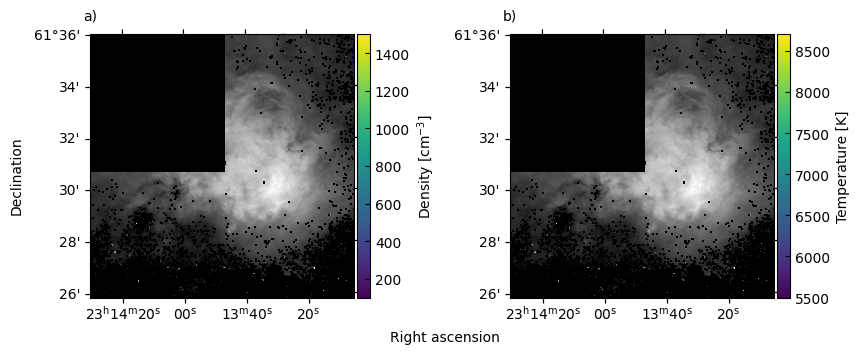

In [2]:
maps = [map_.get_reprojection_on(background) for map_ in [
    Map.load("data/sh158_article/dens_it_sii_sans_fcorr_nii_plus_plusmin_pouss_seuil_errt_1000.fits"),
    Map.load("data/sh158_article/temp_it_nii_plus_sii_sans_fcorr_plusmin_pouss_seuil_errt_1000.fits"),
]]

fig = plt.figure(figsize=(10,10))
plt.tight_layout()

ax = fig.add_subplot(121, projection=WCS(maps[0].header))
format(ax)
imshow = ax.imshow(maps[0].data,
    origin="lower",
    cmap="viridis",
    interpolation=None,
    norm=ImageNormalize(maps[0].data, stretch=LinearStretch(1, 0), vmin=100, vmax=1500),
)
colorbar = fig.colorbar(imshow, fraction=0.047, pad=0.01)
colorbar.ax.tick_params(axis="both", direction="in")
colorbar.set_label("Density [cm$^{-3}$]")
ax.text(0, 1, "a)", transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans))

ax = fig.add_subplot(122, projection=WCS(maps[1].header))
format(ax)
imshow = ax.imshow(maps[1].data,
    origin="lower",
    cmap="viridis",
    interpolation=None,
    norm=ImageNormalize(maps[1].data, stretch=LinearStretch(1, 0), vmin=5500, vmax=8700),
)
colorbar = fig.colorbar(imshow, fraction=0.047, pad=0.01)
colorbar.ax.tick_params(axis="both", direction="in")
colorbar.set_label("Temperature [K]")
ax.text(0, 1, "b)", transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans))

fig.text(0.45, 0.3, "Right ascension")
fig.text(0.07, 0.43, "Declination", rotation=90,)
plt.subplots_adjust(top=0.95, bottom=0.0, left=0.15, right=0.85, hspace=0.00, wspace=0.50)
plt.savefig("figures/sh158/maxime/thermodynamics.pdf", dpi=900, bbox_inches="tight")

### Fig 2

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

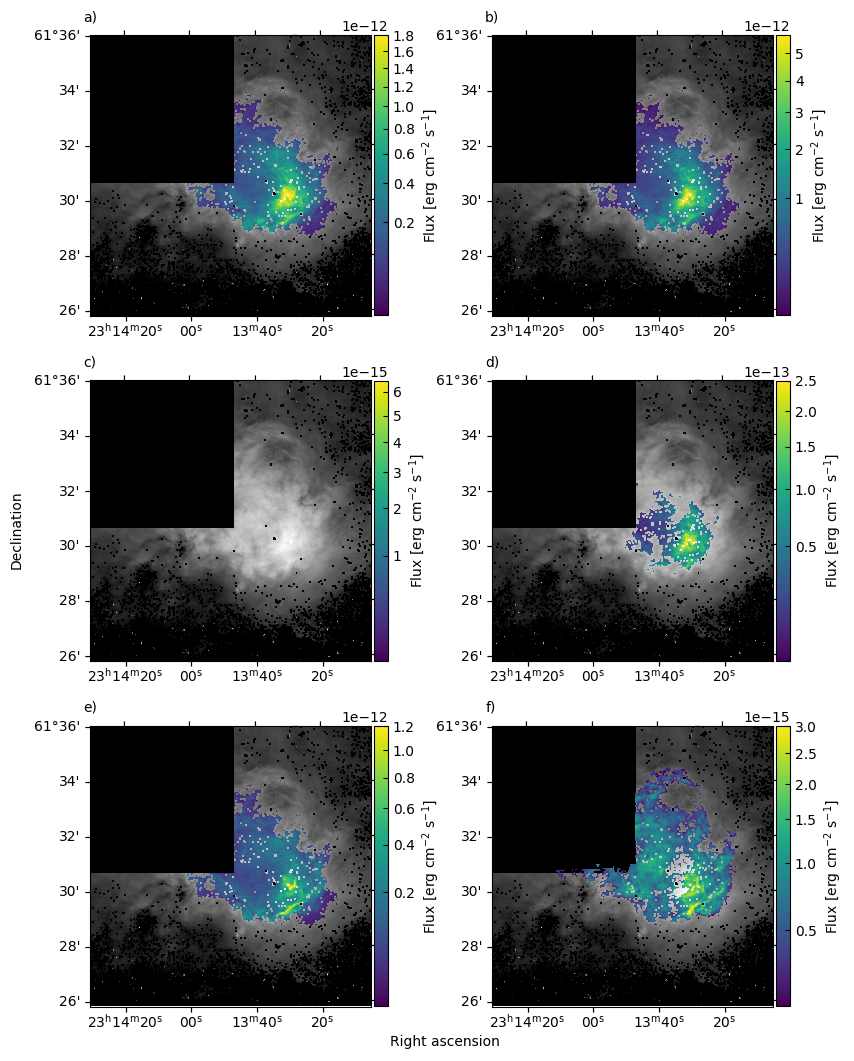

In [113]:
maps = [map_.get_reprojection_on(background) for map_ in [
    Map.load("data/sh158_article/4861_flux_pouss_plus.fits"),
    Map.load("data/sh158_article/5007_flux_pouss_plus.fits"),
    Map.load("data/sh158_article/5755_flux_pouss_plus.fits"),
    Map.load("data/sh158_article/5876_flux_pouss_plus.fits"),
    Map.load("data/sh158_article/6584_flux_pouss_plus.fits"),
    Map.load("data/sh158_article/somme_3116_sans_fcorr.fits"),
]]

fig = plt.figure(figsize=(10,30))
plt.tight_layout()
i = -1

i += 1
ax = fig.add_subplot(3, 2, i + 1, projection=WCS(maps[i].header))
format(ax)
imshow = ax.imshow(maps[i].data,
    origin="lower",
    cmap="viridis",
    norm=ImageNormalize(maps[i].data, stretch=SqrtStretch(), vmin=1e-15, vmax=1.8e-12),
)
colorbar = fig.colorbar(imshow, fraction=0.047, pad=0.01)
colorbar.ax.tick_params(axis="both", direction="in")
colorbar.set_label("Flux [erg cm$^{-2}$ s$^{-1}$]")
ax.text(0, 1, ascii_lowercase[i] + ")", 
        transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans))

i += 1
ax = fig.add_subplot(3, 2, i + 1, projection=WCS(maps[i].header))
format(ax)
imshow = ax.imshow(maps[i].data,
    origin="lower",
    cmap="viridis",
    norm=ImageNormalize(maps[i].data, stretch=SqrtStretch(), vmin=1e-17, vmax=5.7e-12),
)
colorbar = fig.colorbar(imshow, fraction=0.047, pad=0.01)
colorbar.ax.tick_params(axis="both", direction="in")
colorbar.set_label("Flux [erg cm$^{-2}$ s$^{-1}$]")
ax.text(0, 1, ascii_lowercase[i] + ")", 
        transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans))

i += 1
ax = fig.add_subplot(3, 2, i + 1, projection=WCS(maps[i].header))
format(ax)
imshow = ax.imshow(maps[i].data,
    origin="lower",
    cmap="viridis",
    norm=ImageNormalize(maps[i].data, stretch=SqrtStretch(), vmin=1e-16, vmax=6.5e-15),
)
colorbar = fig.colorbar(imshow, fraction=0.047, pad=0.01)
colorbar.ax.tick_params(axis="both", direction="in")
colorbar.set_label("Flux [erg cm$^{-2}$ s$^{-1}$]")
ax.text(0, 1, ascii_lowercase[i] + ")", 
        transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans))

i += 1
ax = fig.add_subplot(3, 2, i + 1, projection=WCS(maps[i].header))
format(ax)
imshow = ax.imshow(maps[i].data,
    origin="lower",
    cmap="viridis",
    norm=ImageNormalize(maps[i].data, stretch=SqrtStretch(), vmin=1e-14, vmax=2.5e-13),
)
colorbar = fig.colorbar(imshow, fraction=0.047, pad=0.01)
colorbar.ax.tick_params(axis="both", direction="in")
colorbar.set_label("Flux [erg cm$^{-2}$ s$^{-1}$]")
ax.text(0, 1, ascii_lowercase[i] + ")", 
        transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans))

i += 1
ax = fig.add_subplot(3, 2, i + 1, projection=WCS(maps[i].header))
format(ax)
imshow = ax.imshow(maps[i].data,
    origin="lower",
    cmap="viridis",
    norm=ImageNormalize(maps[i].data, stretch=SqrtStretch(), vmin=1.8e-15, vmax=1.2e-12),
)
colorbar = fig.colorbar(imshow, fraction=0.047, pad=0.01)
colorbar.ax.tick_params(axis="both", direction="in")
colorbar.set_label("Flux [erg cm$^{-2}$ s$^{-1}$]")
ax.text(0, 1, ascii_lowercase[i] + ")", 
        transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans))

i += 1
ax = fig.add_subplot(3, 2, i + 1, projection=WCS(maps[i].header))
format(ax)
imshow = ax.imshow(maps[i].data,
    origin="lower",
    cmap="viridis",
    norm=ImageNormalize(maps[i].data, stretch=SqrtStretch(), vmin=3e-16, vmax=3e-15),
)
colorbar = fig.colorbar(imshow, fraction=0.047, pad=0.01)
colorbar.ax.tick_params(axis="both", direction="in")
colorbar.set_label("Flux [erg cm$^{-2}$ s$^{-1}$]")
ax.text(0, 1, ascii_lowercase[i] + ")", 
        transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans))

fig.text(0.45, 0.3, "Right ascension")
fig.text(0.07, 0.46, "Declination", rotation=90,)
plt.subplots_adjust(top=0.95, bottom=0.0, left=0.15, right=0.85, hspace=-0.84, wspace=0.35)
plt.savefig("figures/sh158/maxime/emission.pdf", dpi=900, bbox_inches="tight")

### Fig 3

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

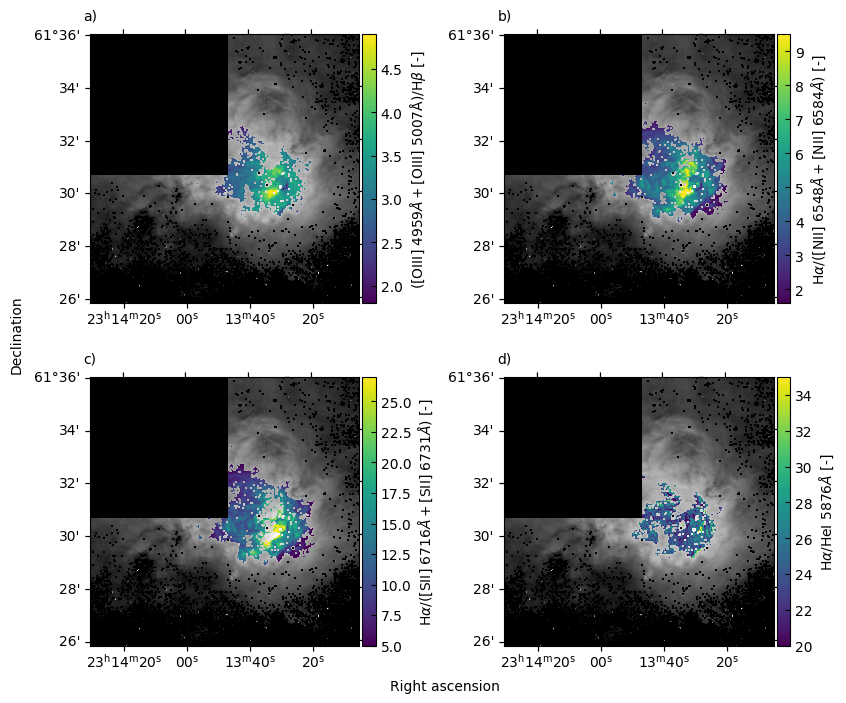

In [18]:
maps = [map_.get_reprojection_on(background) for map_ in [
    Map.load("data/sh158_article/ratio_oiiihb_pouss_plus_seuil.fits"),
    Map.load("data/sh158_article/ratio_hanii_pouss_plus_seuil.fits"),
    Map.load("data/sh158_article/ratio_hasii_pouss_plus_seuil.fits"),
    Map.load("data/sh158_article/ratio_6376_pouss_plus_seuil.fits"),
]]

fig = plt.figure(figsize=(10,20))
plt.tight_layout()
i = -1

i += 1
ax = fig.add_subplot(2, 2, i + 1, projection=WCS(maps[i].header))
format(ax)
imshow = ax.imshow(maps[i].data,
    origin="lower",
    cmap="viridis",
    norm=ImageNormalize(maps[i].data, stretch=LinearStretch(1, 0), vmin=1.8, vmax=4.9),
)
colorbar = fig.colorbar(imshow, fraction=0.047, pad=0.01)
colorbar.ax.tick_params(axis="both", direction="in")
colorbar.set_label(r"([OIII] $4959Å+$[OIII] 5007Å)/H$\beta$ [-]")
ax.text(0, 1, ascii_lowercase[i] + ")", 
        transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans))

i += 1
ax = fig.add_subplot(2, 2, i + 1, projection=WCS(maps[i].header))
format(ax)
imshow = ax.imshow(maps[i].data,
    origin="lower",
    cmap="viridis",
    norm=ImageNormalize(maps[i].data, stretch=LinearStretch(1, 0), vmin=1.6, vmax=9.5),
)
colorbar = fig.colorbar(imshow, fraction=0.047, pad=0.01)
colorbar.ax.tick_params(axis="both", direction="in")
colorbar.set_label(r"H$\alpha$/([NII] $6548Å+$[NII] $6584Å$) [-]")
ax.text(0, 1, ascii_lowercase[i] + ")", 
        transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans))

i += 1
ax = fig.add_subplot(2, 2, i + 1, projection=WCS(maps[i].header))
format(ax)
imshow = ax.imshow(maps[i].data,
    origin="lower",
    cmap="viridis",
    norm=ImageNormalize(maps[i].data, stretch=LinearStretch(1, 0), vmin=5, vmax=27),
)
colorbar = fig.colorbar(imshow, fraction=0.047, pad=0.01)
colorbar.ax.tick_params(axis="both", direction="in")
colorbar.set_label(r"H$\alpha$/([SII] $6716Å+$[SII] $6731Å$) [-]")
ax.text(0, 1, ascii_lowercase[i] + ")", 
        transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans))

i += 1
ax = fig.add_subplot(2, 2, i + 1, projection=WCS(maps[i].header))
format(ax)
imshow = ax.imshow(maps[i].data,
    origin="lower",
    cmap="viridis",
    norm=ImageNormalize(maps[i].data, stretch=LinearStretch(1, 0), vmin=20, vmax=35),
)
colorbar = fig.colorbar(imshow, fraction=0.047, pad=0.01)
colorbar.ax.tick_params(axis="both", direction="in")
colorbar.set_label(r"H$\alpha$/HeI $5876Å$ [-]")
ax.text(0, 1, ascii_lowercase[i] + ")", 
        transform=ax.transAxes + ScaledTranslation(-5 / 72, 10 / 72, fig.dpi_scale_trans))

fig.text(0.45, 0.3, "Right ascension")
fig.text(0.07, 0.46, "Declination", rotation=90,)
plt.subplots_adjust(top=0.95, bottom=0.0, left=0.15, right=0.85, hspace=-0.78, wspace=0.45)
plt.savefig("figures/sh158/maxime/ratio.pdf", dpi=900, bbox_inches="tight")

# Tests

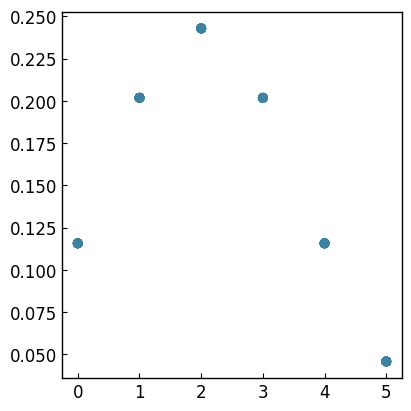

In [5]:
fig = gl.Figure(size=(4,4))

# rand = np.random.normal(5, 1, 100000)
# x = np.linspace(-5, 5, num=100)
# x = np.random.uniform(1,11,100)
x = np.random.choice(6, 100)
# s = np.log(rand/np.nanmedian(rand))


# fig.add_elements(gl.Histogram(
#     # data=s,
#     # data=norm.pdf(np.log(rand/np.nanmedian(rand))),
#     # data=norm.pdf(s),
#     data=norm.pdf(x, loc=0, scale=1),
#     face_color="black",
#     edge_color="none",
#     alpha=1,
#     normalize=False,
#     number_of_bins=25,
#     # number_of_bins=int(((np.nanmax(masked.data) + bin_width - np.nanmin(masked.data)) / bin_width)),
#     show_params=False
# ))

# fig.show()
# fig = gl.Figure(size=(4,4))
# s = np.log(x/np.nanmedian(x))
s = x
fig.add_elements(gl.Scatter(
    x_data=s,
    y_data=pdf(s, np.nanstd(s), np.nanmedian(s)),
))

fig.show()

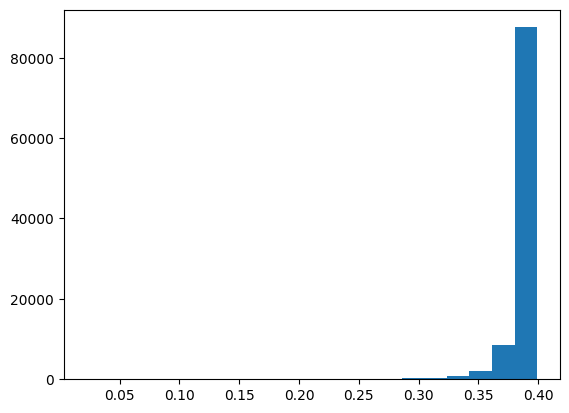

In [6]:
import matplotlib.pyplot as plt
rand = np.random.normal(5, 1, 100000)

plt.hist(
    x=norm.pdf(np.log(rand/np.nanmedian(rand))),
    bins=20,
)

plt.show()

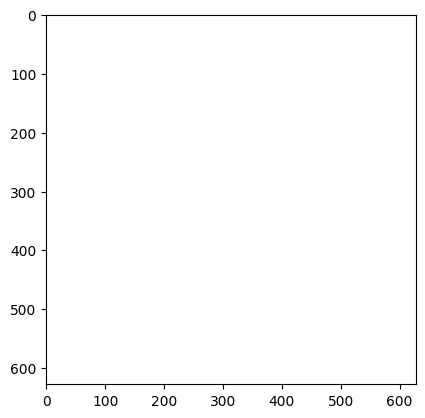

In [3]:
plt.imshow(fits.open("data/sh158_article/dens_it_sii_sans_fcorr_nii_plus_plusmin_pouss_seuil_errt_1000.fits")[0].data)
plt.savefig("t.pdf")